### Please see the before notebook for all the preprocessing steps done on the amazon fine food reviews dataset.
### Used the nlp techniques like bag of words unigram, bigram, TFIDF, avg w2v, TFIDF avg w2v and converted all the reviews of the amazon fine food reviews to vectors in the previous notebook.
### In this notebook we will directly load the vectors that we saved from the previous notebook and apply knn algorithm and performs the model evaluation on the review vectors.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import time
from datetime import timedelta

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Importing the train, cross validataion and test dataset

To see the preprocessing steps, see the before notebook

In [2]:
train_df = pd.read_csv('train_df.csv')
cv_df = pd.read_csv('cv_df.csv')
test_df = pd.read_csv('test_df.csv')

In [3]:
#test_df = cv_df[16000:20000]
#cv_df = cv_df[12000:16000]
#train_df = train_df[:12000]

In [3]:
# remove this line
train_df.shape, test_df.shape, cv_df.shape

((60000, 12), (20000, 12), (20000, 12))

In [46]:
from prettytable import PrettyTable
output = PrettyTable()
output.field_names = ['Method', 'Model', 'Hyper Parameter', 'Cross Validation Accuracy', 'Test Accuracy', 'Test F1-score']

# Bag of Words (BoW)

In [5]:
# importing the unigram train validation and test vectors and apply knn algorithm
unigram_vectors = np.load('unigram_vectors.npz')
unigram_vectors.files

['unigram_xtrain_svd_data', 'unigram_xcv_svd_data', 'unigram_xtest_svd_data']

In [6]:
unigram_xtrain_svd_data = unigram_vectors['unigram_xtrain_svd_data']
unigram_xcv_svd_data = unigram_vectors['unigram_xcv_svd_data']
unigram_xtest_svd_data = unigram_vectors['unigram_xtest_svd_data']

In [7]:
unigram_xtrain_svd_data.shape, unigram_xcv_svd_data.shape, unigram_xtest_svd_data.shape

((60000, 2500), (20000, 2500), (20000, 2500))

In [16]:
def knn_model(x_train, y_train, x_cv, y_cv, x_test, y_test, algo,step):
    '''this function uses the validation dataset to find the optimal k 
    and uses the optimal k and trained algorithm to predict the test data'''
    
    ##finding the optimal k using validation dataset
    print('------------------------------------------------------------')
    print('started finding the optimal k for KNearest neighbours')
    neigh = [x for x in range(1,50,step)]
    acc = []
    best_cv_predict = 0
    for k in neigh:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=algo, n_jobs=-1)
        knn.fit(x_train, y_train)
        #cv_predict = knn.predict(x_cv)
        #if you have enough ram run above code otherwise run below
        predicted_labels = []
        for i in range(0, np.array(x_cv).shape[0], 1000):
            predicted_labels.extend(knn.predict(x_cv[i:i+1000]))
            
        cv_predict = np.array(predicted_labels)
        acc_score = accuracy_score(y_cv, cv_predict)
        acc.append(acc_score)
        if acc_score >= max(acc):
            best_cv_predict = cv_predict
            print('as of now best k is {} with accuracy of {}'.format(k, acc_score))
        
    plt.plot(neigh, acc);
    plt.xticks(neigh);
    plt.title('accuracies on validation dataset with different neighbours');
    plt.show()    
    
    optimal_neighbour = neigh[acc.index(max(acc))]
    print('neighbour which is giving highest accuracy {} on cross vadiation dataset is {}'.format(max(acc), optimal_neighbour))
    
    #confusion matrix of this optimal neighbour on crossvalidation dataset
    cv_cm = pd.crosstab(y_cv, best_cv_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(cv_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on validation dataset with best parameters');
    plt.show()
    
    print('precission recall and f score on best optimal k predicted data of validation dataset is')
    print(classification_report(y_cv, best_cv_predict))
    print('------------------------------------------------------------------------------')
    
    # trainning the algorithm on train data and testing on the test data
    print('training the algoritm using train data and predicting on the test dataset')
    x_train_valid = np.vstack((x_train, x_cv))
    y_train_valid = np.hstack((y_train, y_cv))
    knn = KNeighborsClassifier(n_neighbors=optimal_neighbour, algorithm=algo, n_jobs=-1)
    knn.fit(x_train_valid, y_train_valid)
    #test_predict = knn.predict(x_test)
    
    predicted_list = []
    for i in range(0, np.array(x_test).shape[0], 1000):
        predicted_list.extend(knn.predict(x_test[i:i+1000]))
            
    test_predict = np.array(predicted_list)
    
    print('accuracy on test data is {}'.format(accuracy_score(y_test, test_predict)))
    
    #confusion matrix on test dataset
    test_cm = pd.crosstab(y_test, test_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(test_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on test dataset with best parameters');
    plt.show()
    
    print('precission recall and f score using best optimal k predicted data on test dataset is')
    print(classification_report(y_test, test_predict))

In [9]:
unigram_xtrain_svd_data.shape, train_df.Score.shape

((60000, 2500), (60000,))

### knn model on unigram vectors using bruteforce algorithm

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.79755
as of now best k is 5 with accuracy of 0.8446
as of now best k is 9 with accuracy of 0.85455
as of now best k is 13 with accuracy of 0.85785
as of now best k is 17 with accuracy of 0.85945
as of now best k is 21 with accuracy of 0.8604
as of now best k is 25 with accuracy of 0.86105
as of now best k is 29 with accuracy of 0.8616
as of now best k is 33 with accuracy of 0.86165
as of now best k is 37 with accuracy of 0.86175
as of now best k is 41 with accuracy of 0.86215
as of now best k is 49 with accuracy of 0.86235


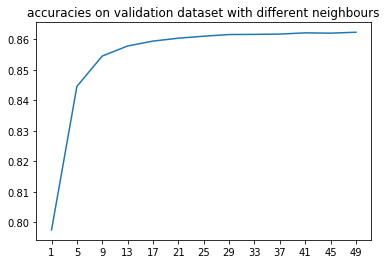

neighbour which is giving highest accuracy 0.86235 on cross vadiation dataset is 49


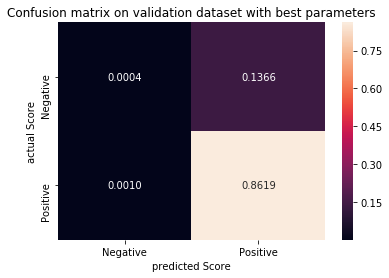

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.31      0.00      0.01      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.59      0.50      0.47     20000
weighted avg       0.79      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.86635


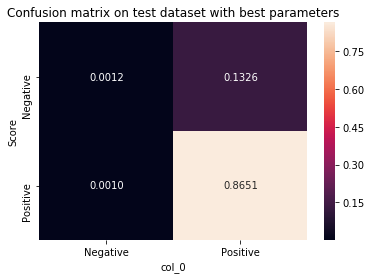

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.53      0.01      0.02      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.70      0.50      0.47     20000
weighted avg       0.82      0.87      0.81     20000

Wall time: 23min 26s


In [10]:
%%time
knn_model(x_train=unigram_xtrain_svd_data, y_train=train_df.Score, x_cv=unigram_xcv_svd_data, y_cv=cv_df.Score, x_test=unigram_xtest_svd_data, y_test=test_df.Score, algo='brute', step=4)

### knn model on unigram vectors using bruteforce algorithm

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.79755
as of now best k is 5 with accuracy of 0.8446
as of now best k is 9 with accuracy of 0.85455
as of now best k is 13 with accuracy of 0.85785
as of now best k is 17 with accuracy of 0.85945
as of now best k is 21 with accuracy of 0.8604
as of now best k is 25 with accuracy of 0.86105
as of now best k is 29 with accuracy of 0.8616
as of now best k is 33 with accuracy of 0.86165
as of now best k is 37 with accuracy of 0.86175
as of now best k is 41 with accuracy of 0.86215
as of now best k is 49 with accuracy of 0.86235


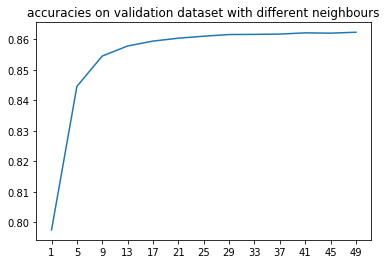

neighbour which is giving highest accuracy 0.86235 on cross vadiation dataset is 49


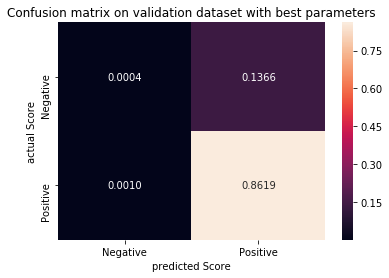

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.31      0.00      0.01      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.59      0.50      0.47     20000
weighted avg       0.79      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.86635


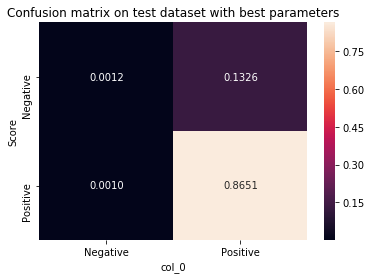

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.53      0.01      0.02      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.70      0.50      0.47     20000
weighted avg       0.82      0.87      0.81     20000

Wall time: 2h 4min 10s


In [11]:
%%time
knn_model(x_train=unigram_xtrain_svd_data, y_train=train_df.Score, x_cv=unigram_xcv_svd_data, y_cv=cv_df.Score, x_test=unigram_xtest_svd_data, y_test=test_df.Score, algo='kd_tree', step=4)

In [47]:
output.add_row(['BOW Unigram', 'KNN', 'k = 49', '86.235', '86.635', 0.47])

## Observation:
1. We are getting an accuracy of  86.235% on validation data set and 86.235% accuracy on test datset using knn
2. we have predicted 13.26% negative reviews as positive reviews using KNN
3. we only predicted 0.10% positive reviews as negative using KNN
4. So we can see that our KNN model is not good in predicting negative reviews
5. KNN recall value on negative reviews is 1%, which is clearly showing that KNN failed to predict the negative reviews correctly.
6. Using bruteforce the knn_model funciton took 23min 26sec whereas kd_tree took 2h 4mins

# Bi-Grams

#### converting data into vectors using bigrams technique

In [12]:
# importing the unigram train validation and test vectors and apply knn algorithm
bigram_vectors = np.load('bigram_vectors.npz')
bigram_vectors.files

['bigram_xtrain_svd_data', 'bigram_xcv_svd_data', 'bigram_xtest_svd_data']

In [13]:
bigram_xtrain_svd_data = bigram_vectors['bigram_xtrain_svd_data']
bigram_xcv_svd_data = bigram_vectors['bigram_xcv_svd_data']
bigram_xtest_svd_data = bigram_vectors['bigram_xtest_svd_data']

In [41]:
bigram_xtrain_svd_data.shape, bigram_xcv_svd_data.shape, bigram_xtest_svd_data.shape

((60000, 3000), (20000, 3000), (20000, 3000))

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.78655
as of now best k is 5 with accuracy of 0.83765
as of now best k is 9 with accuracy of 0.8478
as of now best k is 13 with accuracy of 0.85185
as of now best k is 17 with accuracy of 0.8552
as of now best k is 21 with accuracy of 0.85695
as of now best k is 25 with accuracy of 0.85785
as of now best k is 29 with accuracy of 0.8587
as of now best k is 33 with accuracy of 0.8589
as of now best k is 37 with accuracy of 0.8597
as of now best k is 41 with accuracy of 0.86015
as of now best k is 45 with accuracy of 0.86025
as of now best k is 49 with accuracy of 0.8606


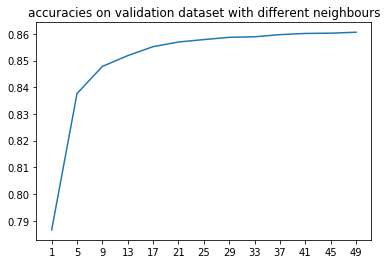

neighbour which is giving highest accuracy 0.8606 on cross vadiation dataset is 49


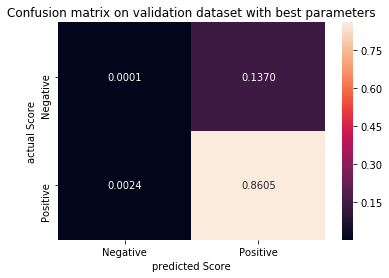

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.04      0.00      0.00      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.45      0.50      0.46     20000
weighted avg       0.75      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.86525


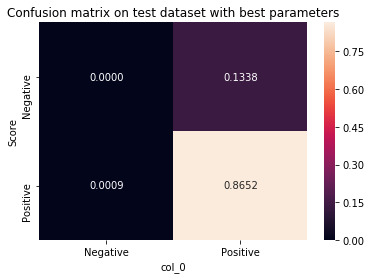

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000

Wall time: 26min 18s


In [14]:
%%time
knn_model(x_train=bigram_xtrain_svd_data, y_train=train_df.Score, x_cv=bigram_xcv_svd_data, y_cv=cv_df.Score, x_test=bigram_xtest_svd_data, y_test=test_df.Score, algo='brute', step=4)

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.78655
as of now best k is 5 with accuracy of 0.83765
as of now best k is 9 with accuracy of 0.8478
as of now best k is 13 with accuracy of 0.85185
as of now best k is 17 with accuracy of 0.8552
as of now best k is 21 with accuracy of 0.85695
as of now best k is 25 with accuracy of 0.85785
as of now best k is 29 with accuracy of 0.8587
as of now best k is 33 with accuracy of 0.8589
as of now best k is 37 with accuracy of 0.8597
as of now best k is 41 with accuracy of 0.86015
as of now best k is 45 with accuracy of 0.86025
as of now best k is 49 with accuracy of 0.8606


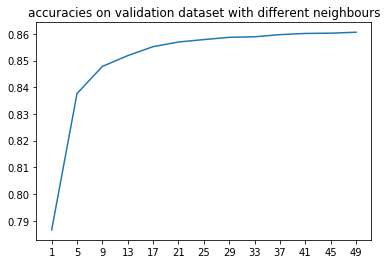

neighbour which is giving highest accuracy 0.8606 on cross vadiation dataset is 49


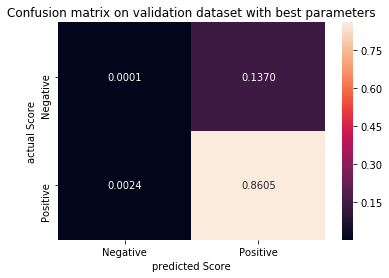

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.04      0.00      0.00      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.45      0.50      0.46     20000
weighted avg       0.75      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.86525


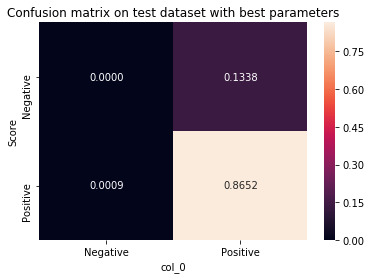

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000

Wall time: 2h 31min 47s


In [15]:
%%time
knn_model(x_train=bigram_xtrain_svd_data, y_train=train_df.Score, x_cv=bigram_xcv_svd_data, y_cv=cv_df.Score, x_test=bigram_xtest_svd_data, y_test=test_df.Score, algo='kd_tree', step=4)

In [48]:
output.add_row(['BOW bigram', 'KNN', 'k = 49', 86.06, 86.525, 0.46])

## Observation:
1. We are getting an accuracy of  86.06% on validation data set and 86.525% accuracy on test datset using knn
2. we have predicted 13.38% negative reviews as positive reviews using KNN
3. we only predicted 0.09% positive reviews as negative using KNN
4. So we can see that our KNN model is not good in predicting negative reviews
5. KNN recall value on negative reviews is 0%, which is clearly showing that KNN failed to predict the negative reviews correctly. Our model is predicting most of the reviews as positive which clearly shows that bigram model is biased towards positive reviews
6. Using bruteforce the knn_model funciton took 23min 18sec whereas kd_tree took 2h 31mins

# TF-IDF

#### converting data into vectors using bigrams technique

In [17]:
# importing the unigram train validation and test vectors and apply knn algorithm
tfidf_vectors = np.load('tfidf_vectors.npz')
tfidf_vectors.files

['tfidf_xtrain_svd_data', 'tfidf_xcv_svd_data', 'tfidf_xtest_svd_data']

In [18]:
tfidf_xtrain_svd_data = tfidf_vectors['tfidf_xtrain_svd_data']
tfidf_xcv_svd_data = tfidf_vectors['tfidf_xcv_svd_data']
tfidf_xtest_svd_data = tfidf_vectors['tfidf_xtest_svd_data']

In [20]:
print(tfidf_xtrain_svd_data.shape, tfidf_xcv_svd_data.shape, tfidf_xtest_svd_data.shape)

(60000, 3000) (20000, 3000) (20000, 3000)


------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.86255
as of now best k is 5 with accuracy of 0.8629
as of now best k is 9 with accuracy of 0.8629
as of now best k is 13 with accuracy of 0.8629
as of now best k is 17 with accuracy of 0.8629
as of now best k is 21 with accuracy of 0.8629
as of now best k is 25 with accuracy of 0.8629
as of now best k is 29 with accuracy of 0.8629
as of now best k is 33 with accuracy of 0.8629
as of now best k is 37 with accuracy of 0.8629
as of now best k is 41 with accuracy of 0.8629
as of now best k is 45 with accuracy of 0.8629
as of now best k is 49 with accuracy of 0.8629


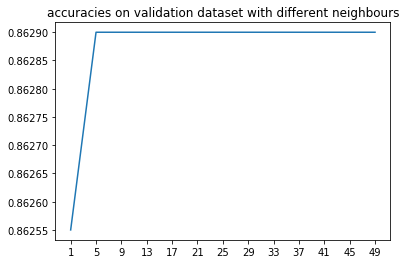

neighbour which is giving highest accuracy 0.8629 on cross vadiation dataset is 5


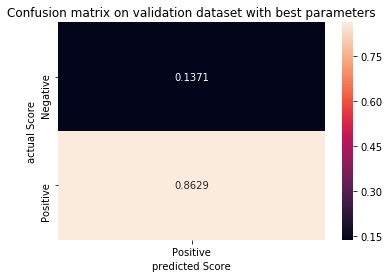

precission recall and f score on best optimal k predicted data of validation dataset is


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.74      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8662


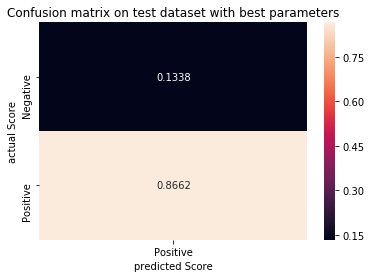

precission recall and f score using best optimal k predicted data on test dataset is


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000

Wall time: 23min 59s


In [21]:
%%time
knn_model(x_train=tfidf_xtrain_svd_data, y_train=train_df.Score, x_cv=tfidf_xcv_svd_data, y_cv=cv_df.Score, x_test=tfidf_xtest_svd_data, y_test=test_df.Score, algo='brute', step=4)

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.86255
as of now best k is 5 with accuracy of 0.8629
as of now best k is 9 with accuracy of 0.8629
as of now best k is 13 with accuracy of 0.8629
as of now best k is 17 with accuracy of 0.8629
as of now best k is 21 with accuracy of 0.8629
as of now best k is 25 with accuracy of 0.8629
as of now best k is 29 with accuracy of 0.8629
as of now best k is 33 with accuracy of 0.8629
as of now best k is 37 with accuracy of 0.8629
as of now best k is 41 with accuracy of 0.8629
as of now best k is 45 with accuracy of 0.8629
as of now best k is 49 with accuracy of 0.8629


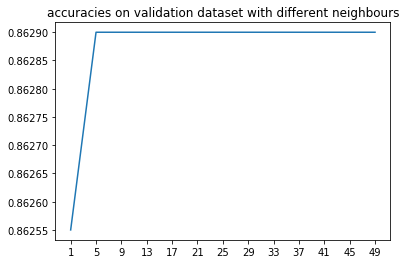

neighbour which is giving highest accuracy 0.8629 on cross vadiation dataset is 5


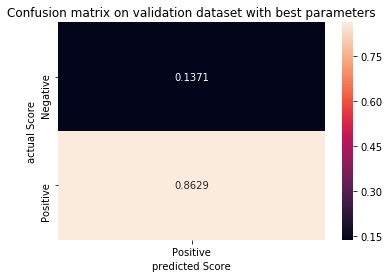

precission recall and f score on best optimal k predicted data of validation dataset is


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2742
    Positive       0.86      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.74      0.86      0.80     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8662


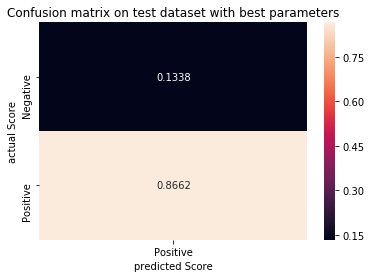

precission recall and f score using best optimal k predicted data on test dataset is


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2676
    Positive       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000

Wall time: 2h 31min 7s


In [22]:
%%time
knn_model(x_train=tfidf_xtrain_svd_data, y_train=train_df.Score, x_cv=tfidf_xcv_svd_data, y_cv=cv_df.Score, x_test=tfidf_xtest_svd_data, y_test=test_df.Score, algo='kd_tree', step=4)

In [49]:
output.add_row(['TF-IDF', 'KNN', 'k = 5', 86.29, 86.62, 0.46])

## Observation:
1. We are getting an accuracy of  86.29% on validation data set and 86.62% accuracy on test datset using knn
2. we have predicted 13.38% negative reviews as positive reviews using KNN
3. we only predicted 0.00% positive reviews as negative using KNN
4. So we can see that our KNN model is predicting all the reviews as positive 
5. KNN recall value on negative reviews is 0%, which is clearly showing that KNN failed to predict the negative reviews correctly. Our model is predicting all of the reviews as positive which clearly shows that tfidf model is completly predicting all the reviews as positive reviews
6. Using bruteforce the knn_model funciton took 23min 59sec whereas kd_tree took 2h 31mins

## Average word 2 vec

In [23]:
# importing the unigram train validation and test vectors and apply knn algorithm
avg_w2v_vectors = np.load('avg_w2v_vectors.npz')
avg_w2v_vectors.files

['w2v_xtrain_vect', 'w2v_xcv_vect', 'w2v_xtest_vect']

In [24]:
w2v_xtrain_vect = avg_w2v_vectors['w2v_xtrain_vect']
w2v_xcv_vect = avg_w2v_vectors['w2v_xcv_vect']
w2v_xtest_vect = avg_w2v_vectors['w2v_xtest_vect']

In [53]:
w2v_xtrain_vect.shape, w2v_xcv_vect.shape, w2v_xtest_vect.shape

((60000, 50), (20000, 50), (20000, 50))

### KNN on average word2vec vectors with brute force

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.7938
as of now best k is 5 with accuracy of 0.8604
as of now best k is 9 with accuracy of 0.8647
as of now best k is 13 with accuracy of 0.8656
as of now best k is 25 with accuracy of 0.8659
as of now best k is 29 with accuracy of 0.86615
as of now best k is 33 with accuracy of 0.8663


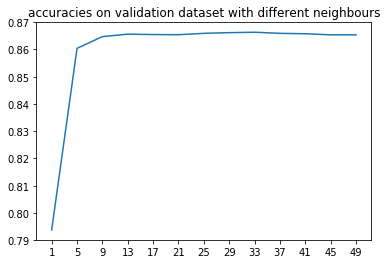

neighbour which is giving highest accuracy 0.8663 on cross vadiation dataset is 33


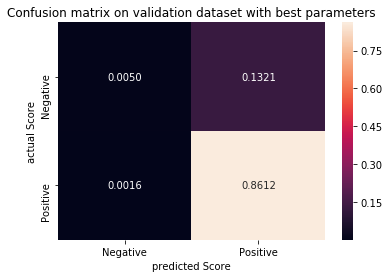

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.75      0.04      0.07      2742
    Positive       0.87      1.00      0.93     17258

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.81      0.52      0.50     20000
weighted avg       0.85      0.87      0.81     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8755


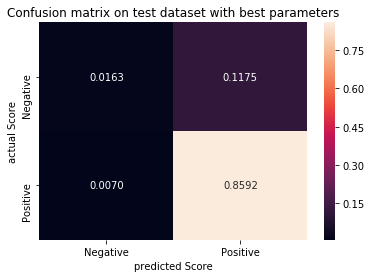

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.70      0.12      0.21      2676
    Positive       0.88      0.99      0.93     17324

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.79      0.56      0.57     20000
weighted avg       0.86      0.88      0.84     20000

Wall time: 13min 51s


In [25]:
%%time
knn_model(x_train=w2v_xtrain_vect, y_train=train_df.Score, x_cv=w2v_xcv_vect, y_cv=cv_df.Score, x_test=w2v_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

## KNN on average word2vec vectors with kd_tree

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.7938
as of now best k is 5 with accuracy of 0.8604
as of now best k is 9 with accuracy of 0.8647
as of now best k is 13 with accuracy of 0.8656
as of now best k is 25 with accuracy of 0.8659
as of now best k is 29 with accuracy of 0.86615
as of now best k is 33 with accuracy of 0.8663


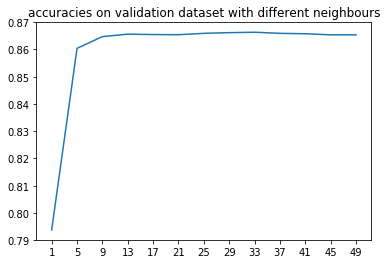

neighbour which is giving highest accuracy 0.8663 on cross vadiation dataset is 33


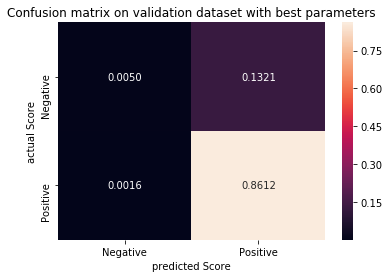

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.75      0.04      0.07      2742
    Positive       0.87      1.00      0.93     17258

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.81      0.52      0.50     20000
weighted avg       0.85      0.87      0.81     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8755


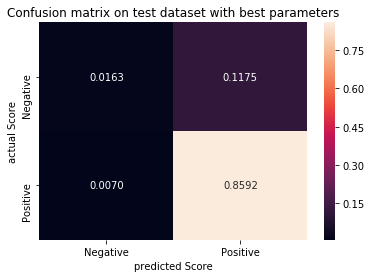

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.70      0.12      0.21      2676
    Positive       0.88      0.99      0.93     17324

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.79      0.56      0.57     20000
weighted avg       0.86      0.88      0.84     20000

Wall time: 7min 18s


In [26]:
%%time
knn_model(x_train=w2v_xtrain_vect, y_train=train_df.Score, x_cv=w2v_xcv_vect, y_cv=cv_df.Score, x_test=w2v_xtest_vect, y_test=test_df.Score, algo='kd_tree', step=4)

In [50]:
output.add_row(['avg-w2v', 'KNN', 'k = 33', 86.63, 87.55, 0.57])

## Observation:
1. We are getting an accuracy of  86.63% on validation data and 87.55% accuracy on test dataset using KNN model
2. we have predicted 11.75% negative reviews as positive reviews using KNN and Naive Bayes also
3. we predicted 0.70% positive reviews as negative using KNN and Naive bayes also
4. So we can see that our KNN model is not good in predicting negative reviews
5. KNN recall value on negative reviews are 12%, which is clearly showing that KNN on average w2v vectors is not able to predict negative reviews correctly
6. 6. Using bruteforce the knn_model funciton took 13min 51sec whereas kd_tree took 7mins 18s

# Average TF IDF W2V

In [32]:
# importing the unigram train validation and test vectors and apply knn algorithm
tfidf_avg_w2v_vectors = np.load('tfidf_avg_w2v_vectors.npz')
tfidf_avg_w2v_vectors.files

['tfidf_w2v_xtrain_vect', 'tfidf_w2v_xcv_vect', 'tfidf_w2v_xtest_vect']

In [37]:
tfidf_w2v_xtrain_vect = tfidf_avg_w2v_vectors['tfidf_w2v_xtrain_vect']
tfidf_w2v_xcv_vect = tfidf_avg_w2v_vectors['tfidf_w2v_xcv_vect']
tfidf_w2v_xtest_vect = tfidf_avg_w2v_vectors['tfidf_w2v_xtest_vect']

## KNN on averageTFIDF word2vec vectors with brute force

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.80365
as of now best k is 5 with accuracy of 0.85325
as of now best k is 9 with accuracy of 0.8604
as of now best k is 13 with accuracy of 0.86305
as of now best k is 17 with accuracy of 0.8632
as of now best k is 21 with accuracy of 0.8639
as of now best k is 25 with accuracy of 0.86425


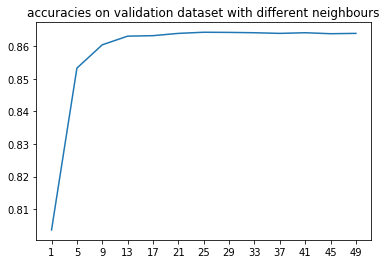

neighbour which is giving highest accuracy 0.86425 on cross vadiation dataset is 25


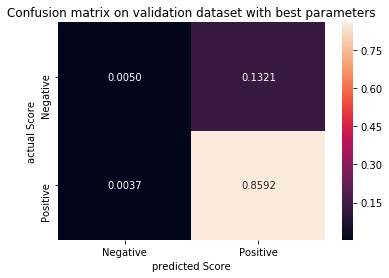

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.58      0.04      0.07      2742
    Positive       0.87      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.72      0.52      0.50     20000
weighted avg       0.83      0.86      0.81     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8713


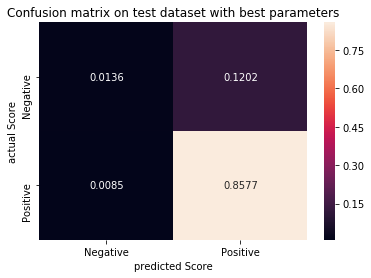

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.62      0.10      0.17      2676
    Positive       0.88      0.99      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.75      0.55      0.55     20000
weighted avg       0.84      0.87      0.83     20000

Wall time: 13min 39s


In [38]:
%%time
knn_model(x_train=tfidf_w2v_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_w2v_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_w2v_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

## KNN on averageTFIDF word2vec vectors with kd_tree

------------------------------------------------------------
started finding the optimal k for KNearest neighbours
as of now best k is 1 with accuracy of 0.80365
as of now best k is 5 with accuracy of 0.85325
as of now best k is 9 with accuracy of 0.8604
as of now best k is 13 with accuracy of 0.86305
as of now best k is 17 with accuracy of 0.8632
as of now best k is 21 with accuracy of 0.8639
as of now best k is 25 with accuracy of 0.86425


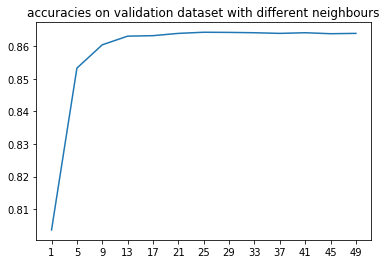

neighbour which is giving highest accuracy 0.86425 on cross vadiation dataset is 25


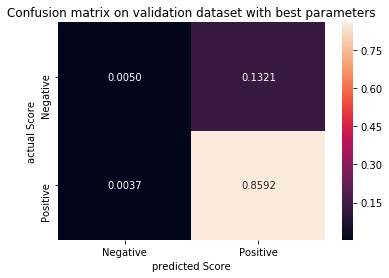

precission recall and f score on best optimal k predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.58      0.04      0.07      2742
    Positive       0.87      1.00      0.93     17258

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.72      0.52      0.50     20000
weighted avg       0.83      0.86      0.81     20000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy on test data is 0.8713


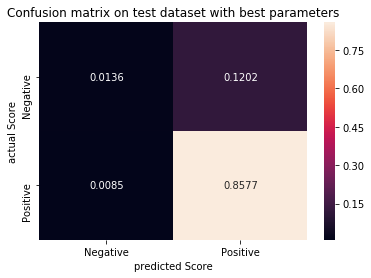

precission recall and f score using best optimal k predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.62      0.10      0.17      2676
    Positive       0.88      0.99      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.75      0.55      0.55     20000
weighted avg       0.84      0.87      0.83     20000

Wall time: 6min 50s


In [39]:
%%time
knn_model(x_train=tfidf_w2v_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_w2v_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_w2v_xtest_vect, y_test=test_df.Score, algo='kd_tree', step=4)

In [51]:
output.add_row(['avg-TFIDF-w2v', 'KNN', 'k = 25', 86.425, 87.13, 0.55])

## Observation:
1. We are getting an accuracy of  86.425% on validation data set and 87.13% accuracy on test datset using knn
2. we have predicted 12.02% negative reviews as positive reviews using KNN
3. we only predicted 0.85% positive reviews as negative using KNN
4. So we can see that our KNN model is predicting most of the reviews as positive 
5. KNN recall value on negative reviews is 10%, which is clearly showing that KNN failed to predict the negative reviews correctly.
6. Using bruteforce the knn_model funciton took 13min 39sec whereas kd_tree took 6mins 50s

## Conclusion:

1. Performed Data wrangling on amazon finefood reviews dataset from Kaggle(see previous notebook
2. Assumed every review with less than 3 rating as negative review and greater than 3 as positive review and stored in a column called Score
3. Converted each review as vectors using techniques like Bag Of Words, Unigram Bigram, TFIDF, average word 2 vec, and TFIDF word 2 vec and done exploratory data analysis.
5. Reduced the dimensions of vectors which are obtained from Bag of words, TFIDF, average word 2 vec and TFIDF word2vec using Truncated SVD(see previous notebook)
6. Used simple crossvalidation on the dimensional reduced data(70-30-30 split), found the optimal k using validation dataset and test dataset.
7. Used the optimal K for training the model and predicted the class variables on the test dataset. Used the average f-score and accuaracy for model evaluation, return the confusion matrix of actual and predicted values.
8. To perform the above steps written a function called knn_model.
9. We are getting the best test accuracy from average word2vec, average TFIDF word2vec, but this is not good as KNN model is predicting most of reviews as positive because of highly imbalanced dataset.
10. We got the best average Test F1 score of KNN model in avg-w2v nlp technique.
11. Our KNN model on reviews is not at all performing well in predicting the negative reviews.
12. Most of the times our model is predicting all the reviews as positive.
13. For all the NLP techniques, exectued the knn_model funciton using both kd_tree and bruteforce algorithm.
14. For unigram and bigram vectors which has 2500 and 3000 features brutforce took only 23min whereas kd tree took more than 2 hours 20minutes
15. For avg_w2v and TFIDF-avg-W2V vectors which has only 50 features, brutforce took 23min whereas kd tree took only 6 minutes
16. From this we can understand that kd_tree is faster if we have less features, but if we have more features kd_tree will be slower than bruteforce.

In [52]:
print(output)

+---------------+-------+-----------------+---------------------------+---------------+---------------+
|     Method    | Model | Hyper Parameter | Cross Validation Accuracy | Test Accuracy | Test F1-score |
+---------------+-------+-----------------+---------------------------+---------------+---------------+
|  BOW Unigram  |  KNN  |      k = 49     |           86.235          |     86.635    |      0.47     |
|   BOW bigram  |  KNN  |      k = 49     |           86.06           |     86.525    |      0.46     |
|     TF-IDF    |  KNN  |      k = 5      |           86.29           |     86.62     |      0.46     |
|    avg-w2v    |  KNN  |      k = 33     |           86.63           |     87.55     |      0.57     |
| avg-TFIDF-w2v |  KNN  |      k = 25     |           86.425          |     87.13     |      0.55     |
+---------------+-------+-----------------+---------------------------+---------------+---------------+
